In [18]:
import pandas as pd
import numpy as np
import sklearn 
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
#!pip install stargazer
from stargazer.stargazer import Stargazer
from statsmodels.iolib.summary2 import summary_col
from matplotlib.ticker import FormatStrFormatter

In [19]:
reg_data = pd.read_csv('uas_data_R2.csv')
imm_data = pd.read_csv('county_imm_population2.csv')
county_data = pd.read_csv('county_population.csv')
state_data = pd.read_csv('imm_state.csv')
race_data = pd.read_csv('county_race_population.csv')

In [20]:
imm_data2 = imm_data[imm_data.columns[3:][::4]]
imm_data2.columns = imm_data.columns[1:][::4]

imm_data3 = imm_data2.loc[1:, :].transpose()
imm_data3.columns = ['pct_imm']
imm_data3['CTYNAME'] = imm_data3.index.str.split(', ').str[0]
imm_data3['STNAME'] = imm_data3.index.str.split(', ').str[1]

imm_data3['pct_imm'] = pd.to_numeric(imm_data3['pct_imm'].str.replace('%', ''))
imm_data3['frac_imm'] = imm_data3['pct_imm'].div(100)

imm_data4 = imm_data3[['CTYNAME', 'STNAME', 'frac_imm']]
imm_data4.dropna(inplace=True)

<ipython-input-20-6c212b09f4bf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imm_data4.dropna(inplace=True)


In [21]:
county_data = county_data[county_data['COUNTY'] != 0]
county_data['STATE'] = ["{:02d}".format(num) for num in county_data['STATE']]
county_data['COUNTY'] = ["{:03d}".format(num) for num in county_data['COUNTY']]
county_data['cnty_FIPS'] = county_data['STATE'] + county_data['COUNTY']
county_data = county_data[['cnty_FIPS', 'POPESTIMATE2020', 'STNAME', 'CTYNAME', 'STATE']].rename(columns = {'POPESTIMATE2020':'population'})

state_data = state_data[['Percent\n foreign born', 'state_fips']]
state_data.columns = ['frac_imm', 'state_FIPS']
state_data['frac_imm'] = state_data['frac_imm']/100
state_data['state_FIPS'] = ["{:02d}".format(num) for num in state_data['state_FIPS']]
state_data.index = state_data['state_FIPS']

In [22]:
race_data2 = race_data.transpose()
race_data2.columns = race_data2.iloc[0, :]
race_data3 = race_data2.iloc[1:, :]

race_data3['CTYNAME'] = race_data3.index.str.split(', ').str[0]
race_data3['STNAME'] = race_data3.index.str.split(', ').str[1]
race_data3.columns = race_data3.columns.str.lstrip()
race_data3.drop(['Not Hispanic or Latino:', 'Population of one race:'], axis=1, inplace=True)
race_data3 = race_data3.apply(lambda x: x.str.replace(',',''))
race_data3.iloc[:, 0:7] = race_data3.iloc[:, 0:7].apply(pd.to_numeric)

race_data4 = race_data3
for col in ['Hispanic or Latino', 'White alone',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Other Pacific Islander alone']:
    if (col != 'Total:'):
        race_data4[col] = race_data3[col]/race_data3['Total:']
        
race_data5 = race_data4[['STNAME', 'CTYNAME', 'Hispanic or Latino', 'White alone',
'Black or African American alone',
'American Indian and Alaska Native alone', 'Asian alone',
'Native Hawaiian and Other Pacific Islander alone']]

<ipython-input-22-98250ace3c31>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data3['CTYNAME'] = race_data3.index.str.split(', ').str[0]
<ipython-input-22-98250ace3c31>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  race_data3['STNAME'] = race_data3.index.str.split(', ').str[1]
<ipython-input-22-98250ace3c31>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [23]:
race_prop_data = county_data.merge(race_data5, how='left', on=['STNAME', 'CTYNAME'])

imm_prop_data = race_prop_data.merge(imm_data4, how = 'left', on=['STNAME', 'CTYNAME'])
for row in imm_prop_data.index:
    state_FIPS = imm_prop_data.loc[row, 'STATE']
    frac_imm = imm_prop_data.loc[row, 'frac_imm']
    imm_prop_data.loc[row, 'frac_imm'] = frac_imm if not pd.isnull(frac_imm) else state_data.loc[state_FIPS, 'frac_imm']
imm_prop_data = imm_prop_data[['cnty_FIPS', 'frac_imm', 
        'Hispanic or Latino', 'White alone',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Other Pacific Islander alone']]
imm_prop_data['cnty_FIPS'] = imm_prop_data['cnty_FIPS'].astype(int)

reg_data2 = reg_data.merge(imm_prop_data, how = 'left', left_on = 'cnty_FIPS', right_on = 'cnty_FIPS')
reg_data2['cnty_FIPS'] = ["{:05d}".format(num) for num in reg_data2['cnty_FIPS']]

In [24]:
#reg_data2['imm'] = reg_data2['immigrant_gen_1 First generation immigrant'] + reg_data2['immigrant_gen_2 Second generation immigrant'] 
reg_data2['imm'] = (reg_data2['immigrant_gen_0 Non-immigrant'] == 0).astype(int)
reg_data2['frac_imm_norm'] = (reg_data2['frac_imm'] - reg_data2['frac_imm'].mean())/reg_data2['frac_imm'].std()

In [25]:
# for i in range(4):
#     reg_data2['frac_imm_norm' + '*imm{}'.format(i)] = reg_data2['frac_imm_norm'] * reg_data2[imm_list[i]]
    
# for i in range(6):
#     reg_data2['imm*' + 'race{}'.format(i)] = reg_data2['imm'] * reg_data2[race_list[i]]
    
reg_data2['frac_imm_norm*imm'] = reg_data2['frac_imm_norm'] * reg_data2['imm']

In [26]:
reg_data2['unemp_exp'] = ((reg_data2['240_unemp_layoff'] == 1) | (reg_data2['250_unemp_layoff'] == 1) | (reg_data2['348_unemp_layoff'] == 1)).astype(int)

In [27]:
reg_data2[reg_data2['unemp_exp'] == 1].groupby('imm').sum()

,Unnamed: 0,uasid,cl014_240,cl014_250,cl014_348,immigrant_gen_0 Non-immigrant,immigrant_gen_1 First generation immigrant,immigrant_gen_2 Second generation immigrant,immigrant_gen_3 Third generation immigrant,hhincome,...,case4,case5,age1,age2,age3,age4,frac_imm,frac_imm_norm,frac_imm_norm*imm,unemp_exp
imm,,,,,,,,,,,,,,,,,,,,,
0,176191,16070580447,16.0,14.0,8.0,99,0,0,0,985,...,24,13,10,33,36,20,12.112,-25.209859,0.000000,99
1,316987,20787973926,27.0,17.0,18.0,0,40,32,45,1254,...,63,8,18,39,36,26,26.916,74.438188,74.438188,119


### Visualizations

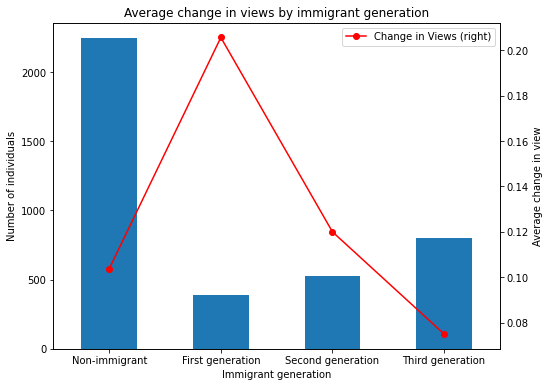

In [28]:
vis_data = reg_data2
vis_data['imm_gen'] = vis_data[['immigrant_gen_0 Non-immigrant',
       'immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant']].idxmax(axis = 1)
imm_counts = vis_data.groupby('imm_gen').count()['uasid'].rename('counts')
imm_view = vis_data.groupby('imm_gen').mean()['cl014_240'].rename('Change in Views')
merged = pd.concat([imm_counts, imm_view], axis = 1)
merged.index = ['Non-immigrant', 'First generation', 'Second generation', 'Third generation']

merged['counts'].plot.bar(figsize=(8, 6))
plt.ylabel("Number of individuals")
plt.xlabel('Immigrant generation')
ax1 = merged['Change in Views'].plot(secondary_y=True, color='r', marker='o')
ax1.set_ylabel('Average change in view')

plt.legend()
plt.title('Average change in views by immigrant generation')
plt.show()

### Oaxaca stuff

In [29]:
# oxaca_means = pd.DataFrame([casedist_native, casedist_imm, casedist_imm - casedist_native]).T.rename(columns = {0:'native', 1:'imm', 2:'imm - native'})
# with open('oxaca_means.html', 'w') as tf:
#      tf.write(oxaca_means.to_html())
        

In [30]:
data_natives = reg_data2[reg_data2['imm'] == 0 | (reg_data2['immigrant_gen_3 Third generation immigrant'] == 1)]
data_imm = reg_data2[(reg_data2['immigrant_gen_2 Second generation immigrant'] == 1) | (reg_data2['immigrant_gen_1 First generation immigrant'] == 1)]

data_imm['cases'] = data_imm[['case1', 'case2', 'case3', 'case4', 'case5']].idxmax(axis = 1)
data_natives['cases'] = data_natives[['case1', 'case2', 'case3', 'case4', 'case5']].idxmax(axis = 1)

<ipython-input-30-49db5259a375>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_imm['cases'] = data_imm[['case1', 'case2', 'case3', 'case4', 'case5']].idxmax(axis = 1)
<ipython-input-30-49db5259a375>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_natives['cases'] = data_natives[['case1', 'case2', 'case3', 'case4', 'case5']].idxmax(axis = 1)


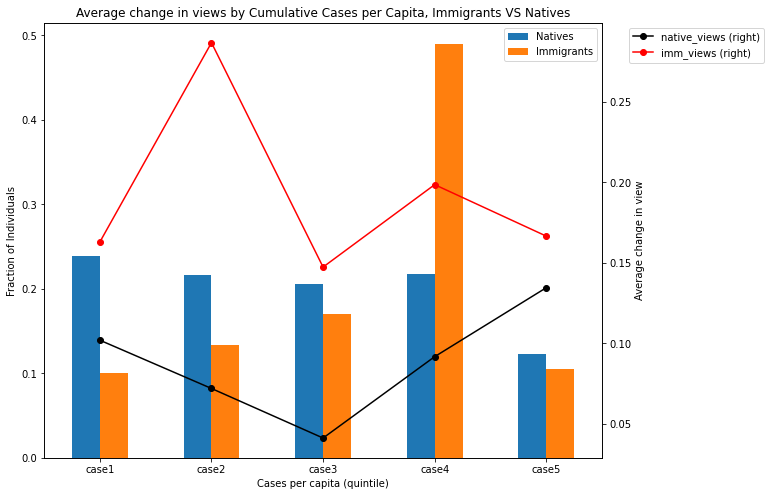

In [31]:
casedist_native = data_natives[['case1', 'case2', 'case3', 'case4', 'case5']].mean()
views_native = data_natives.groupby('cases').mean()['cl014_348'].rename('native_views')
casedist_imm = data_imm[['case1', 'case2', 'case3', 'case4', 'case5']].mean()
views_imm = data_imm.groupby('cases').mean()['cl014_348'].rename('imm_views')

merged = pd.concat([casedist_native, casedist_imm, views_native, views_imm], axis = 1)
merged = merged.rename(columns = {0: 'Natives', 1:"Immigrants"})

merged[['Natives', 'Immigrants']].plot.bar(figsize=(10, 8))
plt.xticks(rotation=0)
plt.xlabel("Cases per capita (quintile)")
plt.ylabel("Fraction of Individuals")
plt.legend(loc='upper left')

ax1 = merged['native_views'].plot(secondary_y=True, color='k', marker='o')
ax1.set_ylabel('Average change in view')
ax2 = merged['imm_views'].plot(secondary_y=True, color='r', marker='o')

plt.title('Average change in views by Cumulative Cases per Capita, Immigrants VS Natives')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

In [32]:
#reg_data2['imm'] = ((reg_data2['immigrant_gen_2 Second generation immigrant'] == 1) | (reg_data2['immigrant_gen_1 First generation immigrant'] == 1)).astype(int)
#reg_data2.to_csv('oxaca_data_R.csv')

## Regressions used

In [83]:
# ## For robustness check with LA county (special sample)
# reg_data2 = reg_data2[reg_data2['cnty_FIPS'] != '06037']

In [34]:
from statsmodels.stats.diagnostic import het_white

#perform White's test
def white_test(result):
    white_test = het_white(result.resid, result.model.exog)

    #define labels to use for output of White's test
    labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

    #print results of White's test
    print(dict(zip(labels, white_test)))


In [94]:
y_simple = reg_data2['cl014_348']
y_simple = y_simple.rename(' Change in education view, July2021')
X_simple = reg_data2[['imm',
                          'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
        'case1', 
        'case2', 
#     'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
        'unemp_exp'
                     ]]

X_simple = sm.add_constant(X_simple)
reg_simple = sm.OLS(y_simple, X_simple)
result_simple = reg_simple.fit(cov_type = 'cluster', cov_kwds={'groups': reg_data2['cnty_FIPS']})
#result_simple = reg_simple.fit(cov_type = 'HC3')

# reg_simple = sm.MNLogit(y_simple, X_simple)
# result_simple = reg_simple.fit()
# result_simple.summary()

print(summary_col([result_simple], stars=True).as_text())


                Change in education view, July2021
--------------------------------------------------
const          0.0120                             
               (0.0285)                           
imm            0.0572***                          
               (0.0168)                           
hhi_c_0        0.0135                             
               (0.0252)                           
hhi_c_20       0.0074                             
               (0.0231)                           
hhi_c_60       -0.0017                            
               (0.0284)                           
hhi_c_80       0.0220                             
               (0.0274)                           
case1          0.0492*                            
               (0.0289)                           
case2          0.0435*                            
               (0.0261)                           
case4          0.0395                             
               (0.0330)       

In [36]:
race_list = ['race_0 hisplatino', 'race_1 White Only', 'race_2 Black Only',
       'race_3 American Indian or Alaska Native Only', 'race_4 Asian Only',
       'race_5 Hawaiian/Pacific Islander Only']
race_short_list = ['hisp', 'white', 'black', 'anative', 'asian', 'pislander']
reg_data2.rename(columns=dict(zip(race_list, race_short_list)), inplace=True)

In [37]:
county_race_list = ['Hispanic or Latino', 'White alone',
       'Black or African American alone',
       'American Indian and Alaska Native alone', 'Asian alone',
       'Native Hawaiian and Other Pacific Islander alone']

top_20 = np.percentile(reg_data2['White alone'], 80)
reg_data2['white_high'] = ((reg_data2['White alone']) > top_20).astype(int)

for i in range(len(county_race_list)):
    cnty_race = county_race_list[i]
    short_race = race_short_list[i]
    top_20 = np.percentile(reg_data2['White alone'], 80)
    reg_data2['{} * imm'.format(short_race)] = reg_data2['imm'] * reg_data2[short_race]
    reg_data2[cnty_race+'_high'] = ((reg_data2['White alone']) > top_20).astype(int)
    reg_data2['high_{}_prop * {}'.format(short_race, short_race)] = reg_data2[cnty_race+'_high'] * reg_data2[short_race]
    reg_data2['high_{}_prop * {} * imm'.format(short_race, short_race)] = reg_data2[cnty_race+'_high'] * reg_data2[short_race] * reg_data2['imm']


# for i in range(len(county_race_list)):
#     cnty_race = county_race_list[i]
#     short_race = race_short_list[i]
#     top_20 = np.percentile(reg_data2[cnty_race], 80)
#     reg_data2['{} * imm'.format(short_race)] = reg_data2['imm'] * reg_data2[short_race]
#     reg_data2[cnty_race+'_high'] = ((reg_data2[cnty_race]) > top_20).astype(int)
#     reg_data2['high_{}_prop * {}'.format(short_race, short_race)] = reg_data2[cnty_race+'_high'] * reg_data2[short_race]
#     reg_data2['high_{}_prop * {} * imm'.format(short_race, short_race)] = reg_data2[cnty_race+'_high'] * reg_data2[short_race] * reg_data2['imm']

##np.percentile(reg_data2['frac_imm_norm'], 80)
reg_data2['frac_imm_high'] = ((reg_data2['frac_imm_norm']) > 1.2855).astype(int)
reg_data2['frac_imm_high*imm'] = reg_data2['frac_imm_high'] * reg_data2['imm']

In [38]:
reg_data2['same_race_high'] = reg_data2['high_anative_prop * anative'] + reg_data2['high_asian_prop * asian'] + reg_data2['high_black_prop * black'] + reg_data2['high_hisp_prop * hisp'] * reg_data2['high_white_prop * white'] +  reg_data2['high_pislander_prop * pislander']
reg_data2['same_race_high * imm'] = reg_data2['same_race_high'] * reg_data2['imm']

In [39]:
reg_data2.loc[(reg_data2['hisp'] + reg_data2['white'] + reg_data2['black'] + reg_data2['anative'] + 
               reg_data2['asian'] + reg_data2['pislander'] == 1), 'race_6 Mixed']=0

reg_data2.loc[(reg_data2['hisp'] + reg_data2['white'] + reg_data2['black'] + reg_data2['anative'] + 
               reg_data2['asian'] + reg_data2['pislander'] > 1), 'race_6 Mixed']=1

reg_data2.loc[reg_data2['race_6 Mixed'] == 1, 'hisp':'pislander']=0

### Has children VS No children

In [40]:
reg_data2['haschild * imm'] = reg_data2['haschild'] * reg_data2['imm']
reg_data2['haschild18 * imm'] = reg_data2['haschild18'] * reg_data2['imm']
reg_data2['haschild_total'] = (reg_data2['haschild'] + reg_data2['haschild18']) > 0
reg_data2['haschild_total'] = pd.to_numeric(reg_data2['haschild_total']).astype(int)
reg_data2['haschild_total * imm'] = reg_data2['haschild_total'] * reg_data2['imm']

In [98]:
y2 = reg_data2['cl014_348']
y2 = y2.rename('y')

## All
X1 = reg_data2[[
    'imm',
    'haschild_total',b
'haschild_total * imm',
#     'haschild18',
#     'haschild18 * imm',
#     'hisp',
#  'black', 'anative', 'asian', 'pislander',
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
#         'case1', 
    'case2', 
    'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
                       ]]
X1 = sm.add_constant(X1)
reg1 = sm.OLS(y2, X1)
result1 = reg1.fit(cov_type='HC3')

## With children < 18
X2 = reg_data2[(reg_data2['haschild']==1)][[
    'imm',
#     'haschild',

#     'hisp',
#  'black', 'anative', 'asian', 'pislander',
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
#         'case1', 
    'case2', 
    'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
                       ]]
X2 = sm.add_constant(X2)
reg2 = sm.OLS(y2[(reg_data2['haschild']==1)], X2)
result2 = reg2.fit(cov_type='HC3')

## With children 18-25
X3 = reg_data2[(reg_data2['haschild18']==1)][[
    'imm',
#     'haschild',

#     'hisp',
#  'black', 'anative', 'asian', 'pislander',
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
#         'case1', 
    'case2', 
    'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
                       ]]
X3 = sm.add_constant(X3)
reg3 = sm.OLS(y2[(reg_data2['haschild18']==1)], X3)
result3 = reg3.fit(cov_type='HC3')

## No children 
X4 = reg_data2[(reg_data2['haschild']==0) & (reg_data2['haschild18']==0)][[
    'imm',
#     'hisp',
#  'black', 'anative', 'asian', 'pislander',
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
#         'case1', 
    'case2', 
    'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
                       ]]
X4 = sm.add_constant(X4)
reg4 = sm.OLS(y2[(reg_data2['haschild']==0) & (reg_data2['haschild18']==0)], X4)
result4 = reg4.fit(cov_type='HC3')



# # print(summary_col([result, result2], stars=True).as_text())
print(summary_col([result1, result2, result3, result4], stars=True).as_text())


                        y I        y II     y III     y IIII  
--------------------------------------------------------------
R-squared            0.0123     0.0264    0.0356    0.0173    
R-squared Adj.       0.0067     0.0073    0.0072    0.0093    
age1                 0.0635     0.0539    0.0568    0.0487    
                     (0.0418)   (0.0800)  (0.0902)  (0.0568)  
age2                 0.0361     0.0191    -0.0179   0.0614    
                     (0.0257)   (0.0440)  (0.0570)  (0.0394)  
age4                 0.0239     0.0544    -0.0309   0.0303    
                     (0.0199)   (0.0640)  (0.0541)  (0.0227)  
case2                -0.0096    -0.0027   -0.1242** 0.0061    
                     (0.0239)   (0.0536)  (0.0618)  (0.0285)  
case3                -0.0509**  -0.1201** -0.1359** -0.0206   
                     (0.0244)   (0.0555)  (0.0643)  (0.0285)  
case4                -0.0130    -0.0095   -0.1153*  0.0009    
                     (0.0276)   (0.0610)  (0.0638)  (0

## High same-race proportion

In [42]:
y2 = reg_data2['cl014_348']
y2 = y2.rename(' Change in education view, July2021')

X_frac_imm = reg_data2[[
    'imm',
#     'high_hisp_prop * hisp',
        'same_race_high', 
    'same_race_high * imm',
#     'high_black_prop * black',
#        'high_anative_prop * anative',
#        'high_asian_prop * asian', 
#        'high_pislander_prop * pislander', 
    'hisp',
 'black', 'anative', 'asian', 'pislander',
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
        'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
                       ]]
X_frac_imm = sm.add_constant(X_frac_imm)
reg = sm.OLS(y2, X_frac_imm)
result = reg.fit()

# X_frac_imm2 = reg_data2[reg_data2['asian'] == 1][[
#     'imm',
# #     'high_hisp_prop * hisp',
# #         'high_white_prop * white', 
# #     'high_black_prop * black',
# #        'high_anative_prop * anative',
#        'high_asian_prop * asian', 
# #        'high_pislander_prop * pislander', 
#     'hisp',
#  'black', 'anative', 'asian', 'pislander',
#         'educ_c_8',  'educ_c_12', 
# #     'educ_c_14', 
#     'educ_c_16', 'educ_c_18', 'educ_c_20', 
#     'hhi_c_0','hhi_c_20', 
# #     'hhi_c_40', 
#     'hhi_c_60', 'hhi_c_80', 
#         'case1', 'case2', 
# #     'case3', 
#     'case4', 'case5',
#     'age1', 
#     'age2', 
# #     'age3', 
#     'age4',
#     'unemp_exp'
#                        ]]
# X_frac_imm2 = sm.add_constant(X_frac_imm2)
# reg2 = sm.OLS(y2[reg_data2['asian'] == 1], X_frac_imm2)
# result2 = reg2.fit()

# # print(summary_col([result, result2], stars=True).as_text())
print(summary_col([result], stars=True).as_text())


                      Change in education view, July2021
--------------------------------------------------------
const                0.0218                             
                     (0.0277)                           
imm                  0.0562***                          
                     (0.0168)                           
same_race_high       -0.0395                            
                     (0.1426)                           
same_race_high * imm -0.0434                            
                     (0.2051)                           
hisp                 0.2260***                          
                     (0.0859)                           
black                0.1218***                          
                     (0.0325)                           
anative              -0.0491                            
                     (0.0890)                           
asian                0.0808**                           
                     (0.0380) 

In [43]:
#reg_data2.to_csv('reg_data_R_mnlogit.csv')

In [44]:
#reg_data2.to_csv('oxaca_data_R.csv')

### Different education levels

In [97]:
reg_data_hs = reg_data2[(reg_data2['educ_c_8'] == 1) | (reg_data2['educ_c_12'] == 1)]
y_hs = reg_data_hs['cl014_348']
y_hs = y_hs.rename('HS and below')
X_hs = reg_data_hs[[
    'imm', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
        'case1', 
    'case2', 
#     'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
        'unemp_exp'
                   ]]
X_hs = sm.add_constant(X_hs)
reg_hs = sm.OLS(y_hs, X_hs)
result_hs = reg_hs.fit(cov_type='cluster', cov_kwds={'groups': reg_data_hs['cnty_FIPS']})
#result_hs = reg_hs.fit(cov_type='HC3')

reg_data_ba = reg_data2[(reg_data2['educ_c_14'] == 1) | (reg_data2['educ_c_16'] == 1)]
y_ba = reg_data_ba['cl014_348']
y_ba = y_ba.rename('Asso/BA')
X_ba = reg_data_ba[[
    'imm', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
        'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
         'unemp_exp'
                   ]]
X_ba = sm.add_constant(X_ba)
reg_ba = sm.OLS(y_ba, X_ba)
result_ba = reg_ba.fit(cov_type='cluster', cov_kwds={'groups': reg_data_ba['cnty_FIPS']})
#result_ba = reg_ba.fit(cov_type='HC3')

reg_data_hi = reg_data2[(reg_data2['educ_c_18'] == 1) | (reg_data2['educ_c_20'] == 1)]
y_hi = reg_data_hi['cl014_348']
y_hi = y_hi.rename('Grad level')
X_hi = reg_data_hi[[
    'imm', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
        'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
#     'age3', 
    'age4',
        'unemp_exp'
                   ]]
X_hi = sm.add_constant(X_hi)
reg_hi = sm.OLS(y_hi, X_hi)
result_hi = reg_hi.fit(cov_type='HC3')

print(summary_col([result_simple, result_hs, result_ba, result_hi], stars=True).as_text())



                Change in education view, July2021 HS and below  Asso/BA  Grad level
------------------------------------------------------------------------------------
const          0.0120                              -0.0225      0.0013    0.0979    
               (0.0285)                            (0.0583)     (0.0373)  (0.0672)  
imm            0.0572***                           0.0722*      0.0576*** 0.0083    
               (0.0168)                            (0.0388)     (0.0215)  (0.0406)  
hhi_c_0        0.0135                              -0.0364      0.0682**  -0.0529   
               (0.0252)                            (0.0471)     (0.0309)  (0.1029)  
hhi_c_20       0.0074                              -0.0339      0.0351    -0.0277   
               (0.0231)                            (0.0486)     (0.0293)  (0.0655)  
hhi_c_60       -0.0017                             0.0021       -0.0111   -0.0063   
               (0.0284)                            (0.0887)     

## Robustness checks

In [64]:
import dowhy
from dowhy import CausalModel
import dowhy.datasets

## Build model
model = CausalModel(
    data=reg_data2,
    treatment="imm",
    outcome="cl014_348",
    common_causes=[
        'frac_imm_norm',
        'frac_imm_norm*imm',
'educ_c_8',  'educ_c_12', 
     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
    'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
        'case1', 'case2', 
     'case3', 
    'case4', 'case5',
    'age1', 
    'age2', 
     'age3', 
    'age4'
                       ],
    instruments=None)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

## Estimate model
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression",
                                test_significance=True
                                 )
print(estimate)

## Refutation tests
res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

res_random=model.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")
print(res_random)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(E[cl_014_348|hhi_c_40,educ_c_14,age4,educ_c_8,age3,case4,frac_imm_norm,
d[imm]                                                                        

                                                                              
educ_c_16,case5,age2,hhi_c_60,age1,case2,educ_c_18,hhi_c_80,educ_c_12,case1,hh
                                                                              

                                                  
i_c_0,case3,frac_imm_norm*imm,educ_c_20,hhi_c_20])
                                                  
Estimand assumption 1, Unconfoundedness: If U→{imm} and U→cl014_348 then P(cl014_348|imm,hhi_c_40,educ_c_14,age4,educ_c_8,age3,case4,frac_imm_norm,educ_c_16,case5,age2,hhi_c_60,age1,case2,educ_c_18,hhi_c_80,educ_c_12,case1,hhi_c_0,case3,frac_imm_norm*imm,educ_c_20,hhi_c_20,U

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}
{'control_value': 0, 'treatment_value': 1, 'test_significance': False, 'evaluate

## CasesPerCapita, Income and Education

In [65]:
y = reg_data['cl014_348']
y = y.rename(' Change in education view, July2021')

In [69]:
# Cases per capita
X_cases = reg_data[['immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant', 
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
         'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
                    'age1', 
                    'age2', 
#                     'age3', 
                    'age4',
#               'case1*imm1', 'case1*imm2', 'case1*imm3',  
#         'case2*imm1', 'case2*imm2', 'case2*imm3',
# #      'case3*imm1', 'case3*imm2', 'case3*imm3', 
#        'case4*imm1', 'case4*imm2', 'case4*imm3',
#         'case5*imm1', 'case5*imm2', 'case5*imm3'
                   ]]
X_cases = sm.add_constant(X_cases)
reg = sm.OLS(y, X_cases)
result = reg.fit()
stargazer_t = Stargazer([result])

print(summary_col(result, stars=True))


                                             Change in education view, July2021
-------------------------------------------------------------------------------
const                                       0.0298                             
                                            (0.0275)                           
immigrant_gen_1 First generation immigrant  0.1786***                          
                                            (0.0274)                           
immigrant_gen_2 Second generation immigrant 0.0540**                           
                                            (0.0245)                           
immigrant_gen_3 Third generation immigrant  0.0120                             
                                            (0.0206)                           
educ_c_8                                    -0.0416                            
                                            (0.1160)                           
educ_c_12                              

In [192]:
# No cases per capita controls
X_nocases = reg_data[['immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant', 
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
                      'age1', 
                      'age2', 
#                       'age3', 
                      'age4'
                     ]]
X_nocases = sm.add_constant(X_nocases)
reg1 = sm.OLS(y, X_nocases)
result1 = reg1.fit()

print(summary_col([result1, result], stars=True))


                                             Change in education view, July2021 I  Change in education view, July2021 II
------------------------------------------------------------------------------------------------------------------------
R-squared                                   0.0159                                0.0207                                
R-squared Adj.                              0.0122                                0.0130                                
age1                                        0.0301                                0.0321                                
                                            (0.0330)                              (0.0333)                              
age2                                        0.0308                                0.0341                                
                                            (0.0220)                              (0.0220)                              
age4                           

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [816]:
# Income
X_income = reg_data[['immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant', 
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
         'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
                    'age1', 
                    'age2', 
#                     'age3', 
                    'age4',
    'hhi_c_0*imm1', 'hhi_c_0*imm2', 'hhi_c_0*imm3', 
    'hhi_c_20*imm1', 'hhi_c_20*imm2', 'hhi_c_20*imm3', 
#     'hhi_c_40*imm1', 'hhi_c_40*imm2', 'hhi_c_40*imm3',
       'hhi_c_60*imm1', 'hhi_c_60*imm2', 'hhi_c_60*imm3', 
 'hhi_c_80*imm1', 'hhi_c_80*imm2', 'hhi_c_80*imm3'
                    ]]
X_income = sm.add_constant(X_income)
reg = sm.OLS(y, X_income)
result = reg.fit()
stargazer_t = Stargazer([result])

print(summary_col(result, stars=True))


                                             Change in education view, July2021
-------------------------------------------------------------------------------
const                                       0.0713**                           
                                            (0.0314)                           
immigrant_gen_1 First generation immigrant  0.1286**                           
                                            (0.0526)                           
immigrant_gen_2 Second generation immigrant 0.0289                             
                                            (0.0478)                           
immigrant_gen_3 Third generation immigrant  -0.0536                            
                                            (0.0387)                           
educ_c_8                                    0.0200                             
                                            (0.1202)                           
educ_c_12                              

In [189]:
# No income controls
X_noincome = reg_data[['immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant', 
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
         'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
                    'age1', 
                    'age2', 
#                     'age3', 
                    'age4',
                      ]]
X_noincome = sm.add_constant(X_noincome)
reg = sm.OLS(y, X_noincome)
result = reg.fit()
stargazer_t = Stargazer([result])

print(summary_col(result, stars=True))


                                             Change in education view, July2021
-------------------------------------------------------------------------------
const                                       0.0353                             
                                            (0.0259)                           
immigrant_gen_1 First generation immigrant  0.1778***                          
                                            (0.0273)                           
immigrant_gen_2 Second generation immigrant 0.0600**                           
                                            (0.0246)                           
immigrant_gen_3 Third generation immigrant  0.0095                             
                                            (0.0208)                           
educ_c_8                                    0.0135                             
                                            (0.1198)                           
educ_c_12                              

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)


In [818]:
# Education
X_educ = reg_data[['immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant', 
        'educ_c_8',  'educ_c_12', 
#     'educ_c_14', 
    'educ_c_16', 'educ_c_18', 'educ_c_20', 
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
         'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
                    'age1', 
                    'age2', 
#                     'age3', 
                    'age4',
        'educ_c_14*imm1', 'educ_c_16*imm1', 'educ_c_18*imm1', 'educ_c_20*imm1',
       'educ_c_8*imm2', 'educ_c_12*imm2', 'educ_c_14*imm2', 'educ_c_16*imm2',
       'educ_c_18*imm2', 'educ_c_20*imm2', 'educ_c_8*imm3', 'educ_c_12*imm3',
       'educ_c_14*imm3', 'educ_c_16*imm3', 'educ_c_18*imm3', 'educ_c_20*imm3'
                  ]]
X_educ = sm.add_constant(X_educ)
reg = sm.OLS(y, X_educ)
result = reg.fit()
stargazer_t = Stargazer([result])

print(summary_col(result, stars=True))


                                             Change in education view, July2021
-------------------------------------------------------------------------------
const                                       0.0585*                            
                                            (0.0305)                           
immigrant_gen_1 First generation immigrant  0.1856***                          
                                            (0.0643)                           
immigrant_gen_2 Second generation immigrant 0.0127                             
                                            (0.0760)                           
immigrant_gen_3 Third generation immigrant  -0.0201                            
                                            (0.0748)                           
educ_c_8                                    0.0230                             
                                            (0.1298)                           
educ_c_12                              

In [819]:
# No education controls
# Education
X_noeduc = reg_data[['immigrant_gen_1 First generation immigrant',
       'immigrant_gen_2 Second generation immigrant',
       'immigrant_gen_3 Third generation immigrant',
    'hhi_c_0','hhi_c_20', 
#     'hhi_c_40', 
    'hhi_c_60', 'hhi_c_80', 
         'case1', 'case2', 
#     'case3', 
    'case4', 'case5',
                    'age1', 
                    'age2', 
#                     'age3', 
                    'age4',
                    ]]
X_noeduc = sm.add_constant(X_noeduc)
reg = sm.OLS(y, X_noeduc)
result = reg.fit()
stargazer_t = Stargazer([result])

print(summary_col(result, stars=True))


                                             Change in education view, July2021
-------------------------------------------------------------------------------
const                                       0.0354                             
                                            (0.0276)                           
immigrant_gen_1 First generation immigrant  0.1796***                          
                                            (0.0271)                           
immigrant_gen_2 Second generation immigrant 0.0613**                           
                                            (0.0246)                           
immigrant_gen_3 Third generation immigrant  0.0143                             
                                            (0.0207)                           
hhi_c_0                                     -0.0205                            
                                            (0.0228)                           
hhi_c_20                               